# Approximating Steel Cased Wells - DC

[Lindsey Heagy](http://github.com/lheagy)

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
from matplotlib import gridspec
import ipywidgets
from string import ascii_lowercase

import discretize
from discretize import utils
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso


import casingSimulations as casingSim

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

In [2]:
# experiment = 1  # 1000 m well, break at 500m, compare with short well
# experiment = 2  # 1000 m well, examine break at every 200m 
# experiment = 3  # 1000 m well, vary the conductivity of the background
# experiment = 4 # flawed well - partial flaw, vary the length

In [3]:
simDir = 'Flawed_DC_small'  # create a simulation directory where results can be saved. 

In [4]:
casing_l = 50
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

print(
    'The casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        casing_l, sigma_back
    )
)

The casing is 50m long, and the conductivity of the background is 0.1 S/m


In [5]:
model = casingSim.model.FlawedCasingInHalfspace(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., 3*np.pi/2., -0.00125],  # put the A electrode just below the surface
    src_b = np.r_[1*casing_l, 3*np.pi/2., -0.00125] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, 3*np.pi/2., -0.00125]  

In [6]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'FlawedCasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 50.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'Flawed_DC_small',
 'filename': 'ModelParameters.json',
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'mur_flaw': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_flaw': 5500000.0,
 'sigma_inside': 0.1,
 'src_a': [0.045000000000000005, 4.71238898038469, -0.00125],
 'src_b': [50.0, 4.71238898038469, -0.00125],
 'surface_z': 0.0,
 'version': '0.0.5'}

In [7]:
copiedmodelparams = {
    key: val for key, val in model.serialize().items() if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}

In [8]:
background = casingSim.model.CasingInHalfspace(
    **copiedmodelparams
)

### Set up the models

In [9]:
flaw_depth = casing_l/2.
flaw_dz = [0.5, 0.05, 0.005]

In [10]:
flawed_models = {}

model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.sigma_flaw = model.sigma_back

for dz in flaw_dz: 
    tmp_model = model.copy()
    tmp_model.flaw_z = np.r_[-dz, 0] - flaw_depth
    
    flawed_models["flaw_{}".format(dz)] = tmp_model

In [11]:
short_casing = model.copy()
short_casing.flaw_z = np.r_[-casing_l, -flaw_depth]
# partial_flaw = model.copy()

flawed_models['short'] = short_casing

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [12]:
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(6)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [13]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 10.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = .0025  # cell size in the z-direction 
domainx2 = 50  # go out 500m from the well

# padding parameters
npadx, npadz = 2, 14  # number of padding cells
pfx2 = 2  # expansion factor for the padding to infinity in the x-direction
pfz = 2

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
#     hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

1202280


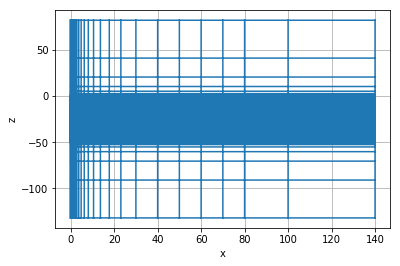

In [14]:
cylMeshGen.mesh.plotGrid()
print(cylMeshGen.mesh.nC)

In [15]:
src_theta = cylMeshGen.hy[0]/2. + np.pi
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [16]:
# Plot the source location

# ax = plt.subplot(111, projection='polar')
# cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
# ax.plot(model.src_a[1], model.src_a[0], 'ro')
# ax.plot(model.src_b[1], model.src_b[0], 'rs')
# ax.set_ylim([0., 3*model.casing_l])

In [17]:
# put the models in a dictionary for convienence 
model_names = ['baseline'] + list(flawed_models.keys())
modelDict = {'baseline': background}
modelDict.update(flawed_models)

In [18]:
for mod in modelDict.values():
    mod.src_a[1] = src_theta
    mod.src_b[1] = src_theta

In [19]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in modelDict.items()
    ]
)

In [20]:
modelDict

{'baseline': <casingSimulations.model.CasingInHalfspace at 0x1065b8b00>,
 'flaw_0.005': <casingSimulations.model.FlawedCasingInHalfspace at 0x109afba90>,
 'flaw_0.05': <casingSimulations.model.FlawedCasingInHalfspace at 0x109afbb00>,
 'flaw_0.5': <casingSimulations.model.FlawedCasingInHalfspace at 0x109afba20>,
 'short': <casingSimulations.model.FlawedCasingInHalfspace at 0x109afb5c0>}

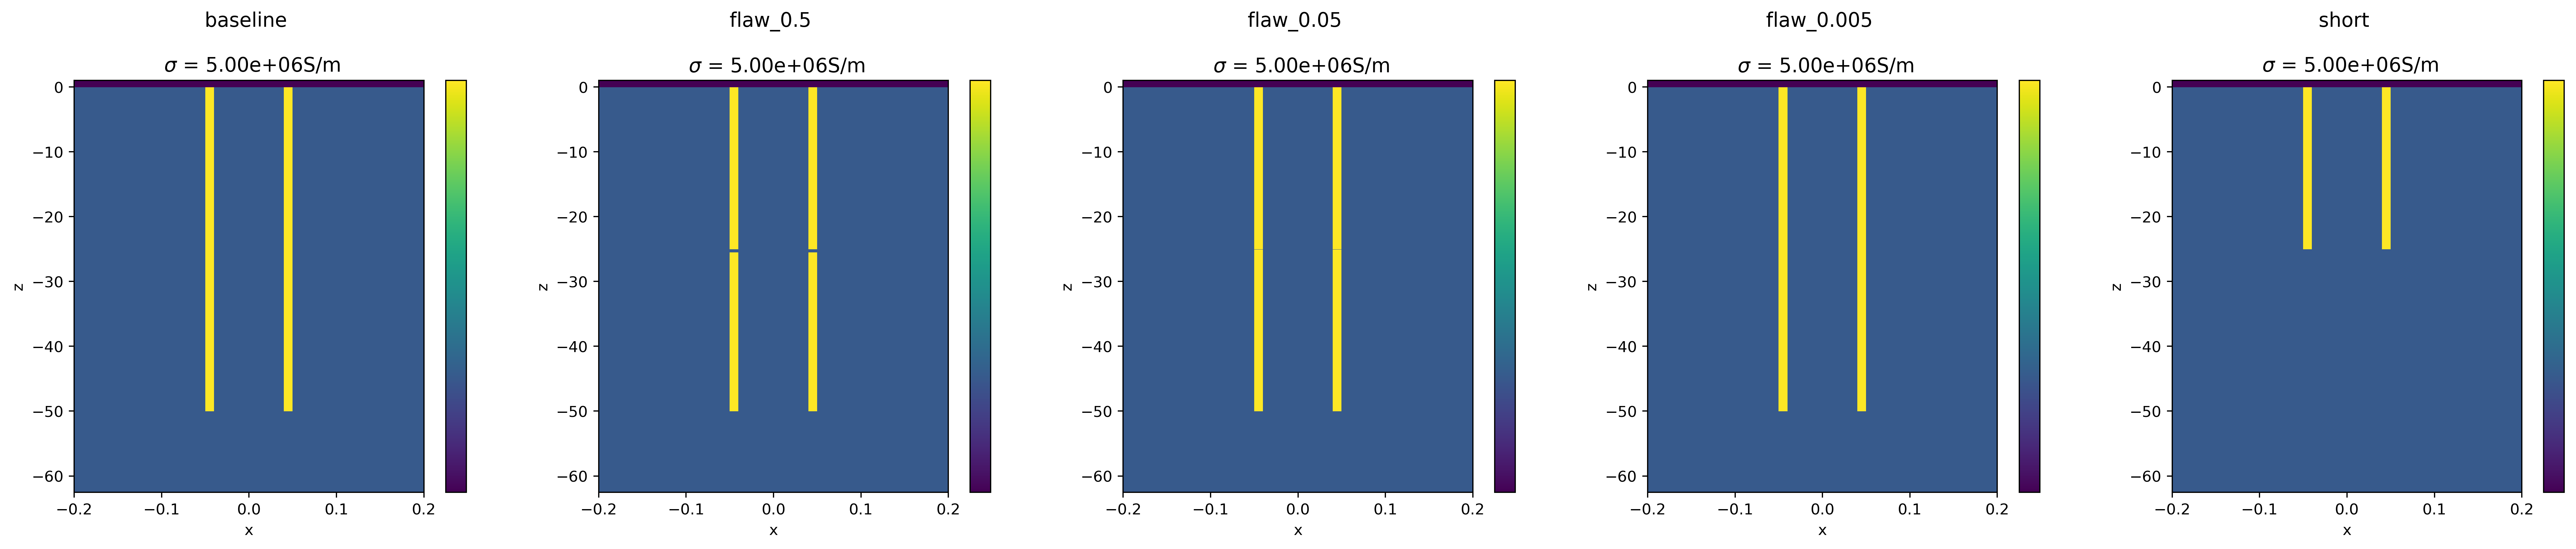

In [21]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l*1.25, 1]
    

theta_ind = 0

plot_models = model_names

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [22]:
model.src_a, model.src_b

(array([ 4.50000000e-02,  6.28318531e+00, -1.25000000e-03]),
 array([ 5.00000000e+01,  6.28318531e+00, -1.25000000e-03]))

In [23]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

# src_locs = [25, 50, 75, 100, 250, 500, 750, 1000., 2000.]
src_locs = [50.]

src_b = np.vstack(
    [[loc, model.src_b[1], model.src_b[2]] for loc in src_locs]
)

src_a = np.ones((src_b.shape[0], 1)) * model.src_a

In [24]:
src_b

array([[ 5.00000000e+01,  6.28318531e+00, -1.25000000e-03]])

## set up a DC simulation

In [25]:
# model_names = ["baseline", "flawed"]

In [26]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=modelDict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [27]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running baseline ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 7.4752209186553955


--- Running flaw_0.5 ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 6.991652965545654


--- Running flaw_0.05 ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 6.986582040786743


--- Running flaw_0.005 ---
Validating parameters...
      max x: 140.0, min z: -131.92749999999998, max z: 81.9274999999545, nC: 1202280
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed tim

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [28]:
def plot_radial_efields(
    ax=None, key="baseline", src_ind=0, xlim=[5., 200.], 
    theta_ind=1, color_ind=0, 
    label=None, include_baseline=True
):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
    
    if label is None:
        label=key 
        
#     for i, key in enumerate(model_names):
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict['baseline'].survey.srcList[src_ind]
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh, field=np.absolute(f[src,'e']), pltType='semilogy',
        ax=ax[0], theta_ind=theta_ind, xlim=xlim, label=label, color_ind=color_ind
    )
    
    if include_baseline is True: 
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=np.absolute(fieldsDict['baseline'][baseline_src,'e']), pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, label='baseline' if label is None else None, 
            color='k'
        )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )

    ax[0].set_ylabel('Electric Field (V/m)')
    ax[1].set_ylabel('percent difference')
    
    ax[2].set_ylim([0., 100.])
    ax[0].set_title("{:1.1f}\n{:1.1f}".format(src_locs[src_ind], cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    
#     [a.set_ylim([1e-7, 1e-3]) for a in ax[:2]]
    [a.legend() for a in ax]

In [29]:
from SimPEG import DC

In [30]:
# %%time

# data_dict = {}
# for key in model_names:
#     model = physpropsDict[key].model
#     simDict[key].prob.model = model
#     data_dict[key] = Data(simDict[key].survey, simDict[key].survey.dpred(model, f=fieldsDict[key]))

In [31]:
# for key in model_names:
#     simDict[key].survey.dobs = data_dict[key].tovec()

In [32]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, primary_key='baseline', model_keys=model_names
)

In [33]:
viewer.widget_cross_section(defaults={"min_depth":0, "max_depth":casing_l*1.25})

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=0.0, description='min_depth'), FloatText(value=62.5, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline', 'flaw_0.5', 'flaw_0.05', 'flaw_0.005', 'short', 'all'), value='baseline'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge'), value='sigma'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

interactive(children=(FloatText(value=50.0, description='max_r'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline', 'flaw_0.5', 'flaw_0.05', 'flaw_0.005', 'short', 'all'), value='baseline'), ToggleButtons(description='view', index=1, options=('sigma', 'e', 'j', 'phi', 'charge'), value='e'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=10, description='z_ind', max=20037), Checkbox(value=False, description='use_aspect'), Checkbox(value=False, description='rotate'), IntSlider(value=10, description='k', max=50), FloatText(value=0.0, description='theta_shift'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

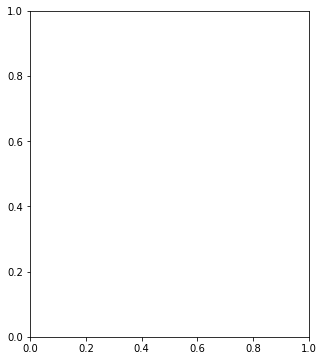

In [34]:
viewer.widget_depth_slice(defaults={"z_ind": 10, 'view': 'e', 'max_r':50})

In [35]:
mesh = cylMeshGen.mesh

In [36]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="baseline"
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
    ax.plot(
        -z_charges, charges, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle
    )
        

In [37]:
from matplotlib import rcParams
rcParams['font.size'] = 14

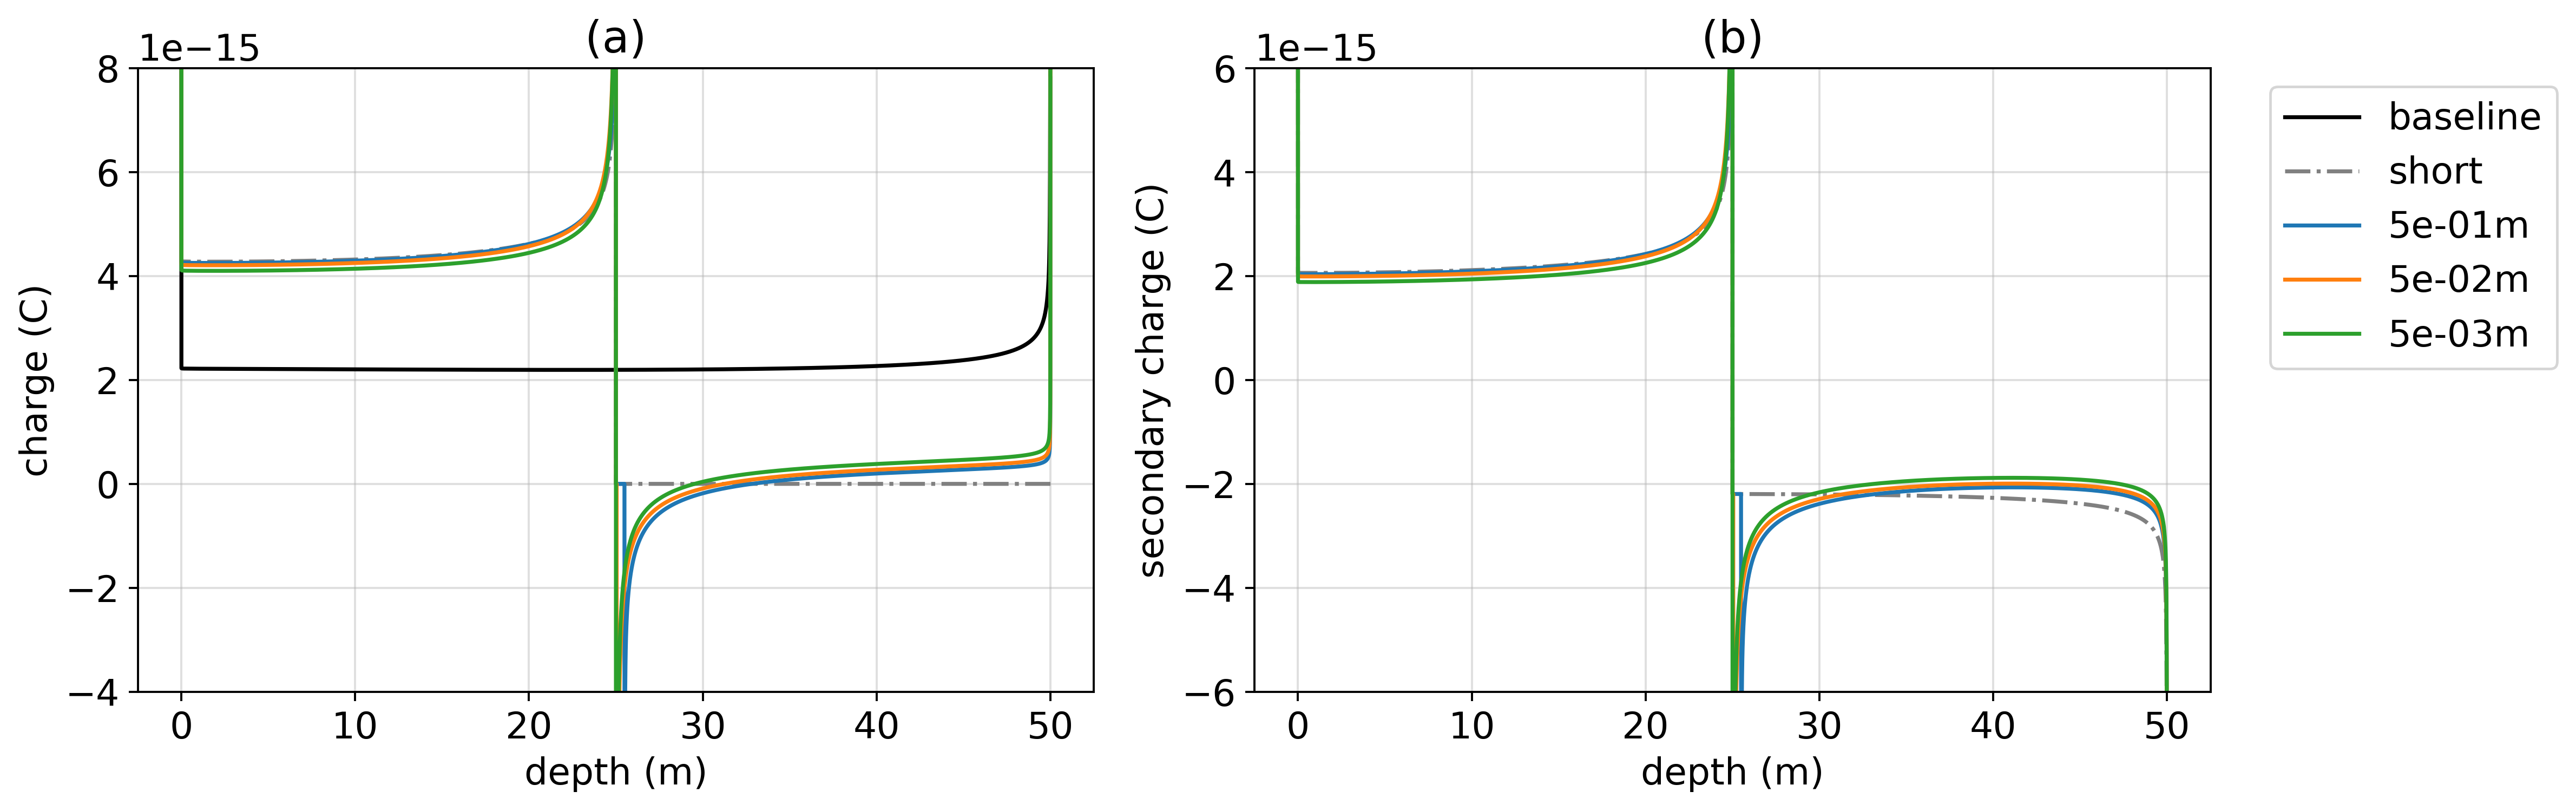

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), dpi = 350)

primary_key = "baseline"
src_ind = 0
ylim = 8e-15*np.r_[-1, 1]

plot_models = ["baseline", "short"] + ["flaw_{}".format(dz) for dz in flaw_dz]

for i, key in enumerate(plot_models):
    
    label = key if key in ["baseline", "short"] else "{:1.0e}m".format(float(key.split("_")[-1]))
    
    plot_charge(
        ax=ax[0], key=key, color_ind=i-2 if key != primary_key else None, 
        color = "k" if key == primary_key else "0.5" if key == "short" else None,
        src_ind=src_ind, label=label, linestyle = '-.' if key == "short" else None 
    )
    if key != primary_key:
        plot_charge(
            ax=ax[1], key=key, color_ind=i-2 if key != primary_key else None, 
            color = "k" if key == primary_key else "0.5" if key == "short" else None,
            src_ind=src_ind, label=label, secondary=True, linestyle = '-.' if key == "short" else None
        )

for i, a in enumerate(ax):
#     a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge (C)' if i == 0 else 'secondary charge (C)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)
    
ax[0].set_ylim([-4e-15, 8e-15])
ax[1].set_ylim(6e-15*np.r_[-1, 1])
#     a.set_xlim(1e-4, 20-1e-4)

ax[0].legend(bbox_to_anchor=[2.55, 1])

plt.tight_layout()
fig.savefig('casing_charge_flawdz', dpi=350, bbox_inches="tight")

In [39]:
from matplotlib import rcParams, ticker
rcParams['font.size'] = 12

AssertionError: The provided model_key, flawed, is not in the allowed model_key list ['baseline', 'flaw_0.5', 'flaw_0.05', 'flaw_0.005', 'short']

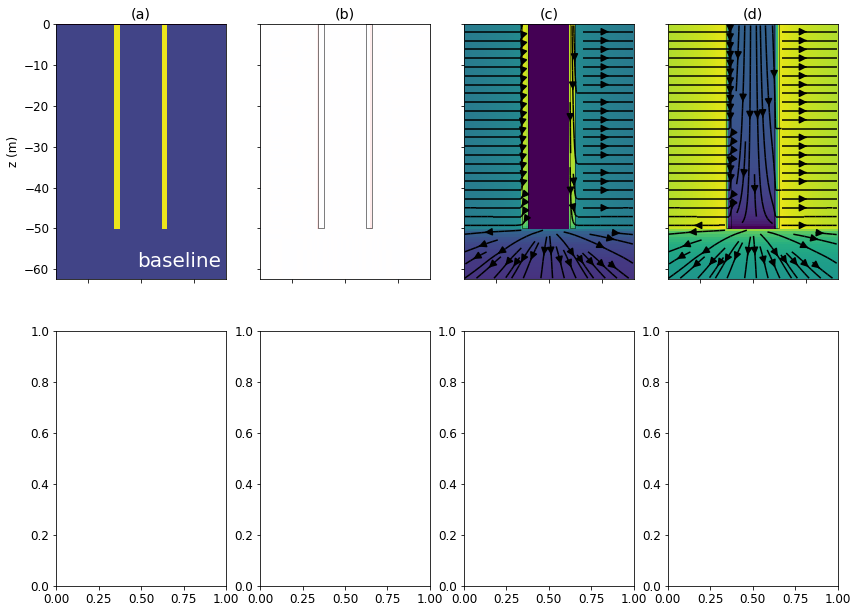

In [40]:
keys = ['baseline', 'flawed']


fig, ax = plt.subplots(len(keys), 4, figsize=(4*3.5, len(keys)*5))
fig.subplots_adjust(bottom=0.1)

max_r = 0.16
min_depth = 0
max_depth = casing_l*1.25
theta_ind = 0

zlim = np.r_[-max_depth, -min_depth]
xlim = max_r * np.r_[-1., 1.]
stream_opts = {"color":"k", "arrowsize":1.5}

for i, key in enumerate(keys):
    
    sigma_out = viewer.plot_cross_section(
        ax=ax[i][0], 
        clim=np.r_[1e-3, 1e7],
        xlim=xlim, 
        zlim=zlim,
        view='sigma', 
        theta_ind=theta_ind, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=False,
        stream_opts=stream_opts
    )
    ax[i][0].text(max_r - 0.01, -max_depth*0.95, key, color='w', fontsize=20, horizontalalignment="right")
    
    charge_out = viewer.plot_cross_section(
        ax=ax[i][1], 
        clim=3e-14 * np.r_[-1, 1],
        xlim=xlim, 
        zlim=zlim,
        view='charge', 
        theta_ind=theta_ind, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        stream_opts=stream_opts
    )
    
    
    currents_out = viewer.plot_cross_section(
        ax=ax[i][2], 
        clim= np.r_[1e-5, 1e3],
        xlim=xlim, 
        zlim=zlim,
        view='j', 
        theta_ind=theta_ind, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    efields_out = viewer.plot_cross_section(
        ax=ax[i][3], 
        clim= np.r_[1e-6, 1],
        xlim=xlim, 
        zlim=zlim,
        view='e', 
        theta_ind=theta_ind, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    
    if i == 0: 
        for j, a in enumerate(ax[i]):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            a.set_ylabel('z (m)')
            a.set_title('({})'.format(ascii_lowercase[j]))
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    else:
        for j, a in enumerate(ax[i]):
            a.set_xlabel('x (m)')
            a.set_title('')
            a.set_ylabel('z (m)')
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    
# cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
# cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')
        
plt.tight_layout()

for i, out, label in zip(
    np.arange(4), 
    [sigma_out, charge_out, currents_out, efields_out],
    ['conductivity (S/m)', 'charge (C)', 'current density (A/m$^2$)', 'electric field (V/m)'],
#     [None, None, 'min', 'min']
):
    x = ax[1][i].figbox.corners()[0, 0]
    cbar_ax = fig.add_axes([x+0.025, -0.01, 0.175, 0.015])
    cb = fig.colorbar(
        out[0], cbar_ax, orientation="horizontal"
    )
    cb.set_label(label)
    cb.set_ticks([cb.vmin, cb.vmax])
    cb.update_ticks()

plt.show() 

# fig.savefig('casing_integrity_basics', bbox_inches="tight")

In [ ]:
src_locs

In [ ]:
cylMeshGen.mesh.hy[0]/2.

In [ ]:
# src_inds = [4, 5, 6, 8] 
src_inds = [0]
fig, ax = plt.subplots(3, len(src_inds), figsize=(5*len(src_inds), 12)) #, dpi=300) 
e_clim = [1e-7, 1e-4]
percent_clim = [10, 30]

key = "flawed"

# fig.subplots_adjust(bottom=0.8)
max_r = 1250

for i, src_ind in enumerate(src_inds):
    
    out_primary = viewer.plot_depth_slice(
        ax=ax[0, i], model_key=key, prim_sec="primary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = e_clim, show_cb = True if i == len(src_inds) -1 else False
    )
    
    out_secondary = viewer.plot_depth_slice(
        ax=ax[1, i], model_key=key, prim_sec="secondary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = e_clim, show_cb = True if i == len(src_inds) -1 else False
    )
    
    
    out_percent = viewer.plot_depth_slice(
        ax=ax[2, i], model_key=key, prim_sec="percent", denominator="radial",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = percent_clim, show_cb = True if i == len(src_inds) -1 else False
    )
    
    if i == len(src_inds) - 1:
        out_primary[-1].set_label('primary electric field (V/m)')
        out_secondary[-1].set_label('secondary electric field (V/m)')
        out_percent[-1].set_label('secondary electric field (%)')

    
    for j, a in enumerate(ax[:, i]):
#         a.plot([0, 0], [0, max_r], 'w:')
        a.plot(0, 0, 'ro')
        a.plot(-src_locs[src_ind], 0, 'ro')
        a.set_xlabel('x (m)')
        a.set_ylabel('y (m)')
        
        # titles
        a.set_title("({})".format(ascii_lowercase[i]) if j == 0 else "")
        
        if i > 0:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
        
        if j < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
    
# for a in ax[1:]:
#     a.set_ylabel('')
#     a.set_yticklabels(['']*len(a.get_yticklabels()))

# cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
# cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
# cb.set_label("electric field (V/m)")

plt.tight_layout()

# fig.savefig('integrity_e_fields', dpi=350)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [1., 30.]
ylim = [1e-4, 1e-1]
ylim_percent = [0, 100]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

# unit = " m" if experiment == 2 else " S/m"

for i, key in enumerate(model_names): 
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict["baseline"].survey.srcList[src_ind]
    label=key

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=i-1 if i !=0 else None, color='k' if i == 0 else None
    )
    
    if key != 'baseline':
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=(
                np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
            ),
            pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
            label=label, color_ind=i-1
        )

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=100*(
                np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
                (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
            ),
            pltType='plot', ax=ax[2], theta_ind=theta_ind,
            label=label, color_ind=i-1
        )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    if i == 0:
        a.legend(loc=1)
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
#         a.text(xlim[0]+15, noise_floor*0.5, "noise floor")

    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
#         a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")
        
plt.tight_layout()

fig.savefig('integrity_depth', bbox_inches="tight", dpi=350)

In [ ]:
model_names

## Experiment 3

In [ ]:
from string import ascii_lowercase

In [ ]:
conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
conductivities

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 5
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

unit = " m" if experiment == 1 else " S/m"

for i, sigma in enumerate(conductivities): 
    
    key = "flaw_{}".format(sigma)
    baseline_key = "baseline_{}".format(sigma)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict[baseline_key].survey.srcList[src_ind]
    label="{:1.0e} {}".format(sigma, unit)

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=i
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(fieldsDict[baseline_key][baseline_src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind, color_ind=i, linestyle="--"
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
        label=label, color_ind=i
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind,
        label=label, color_ind=i
    )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    if i == 0:
        a.legend(loc=1)
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")        
plt.tight_layout()

fig.savefig('integrity_conductivity', bbox_inches="tight", dpi=350)

## Experiment 4

In [ ]:
model_names

In [ ]:
flaw_extent

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 1
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4
eps = 1e-20

noise_floor = 1e-7
min_percent = 20

unit = " m" if experiment == 1 else " S/m"

baseline_key = "baseline"
baseline_src = simDict[baseline_key].survey.srcList[src_ind]
baseline_f = fieldsDict[baseline_key][baseline_src,'e']

casingSim.view.plotLinesFx(
    cylMeshGen.mesh,
    field=np.absolute(fieldsDict[baseline_key][baseline_src,'e']),
    pltType='semilogy', ax=ax[0], theta_ind=theta_ind, color="k",
    label="baseline"
)

for i, extent in enumerate(flaw_extent): 
    
    flaw_key = "flaw_{}".format(extent)
    partial_key = "partial_{}".format(extent)
    
    flaw_f = fieldsDict[flaw_key]
    flaw_src = simDict[flaw_key].survey.srcList[src_ind]
    
    partial_f = fieldsDict[partial_key]
    partial_src = simDict[partial_key].survey.srcList[src_ind]
    
    label="{:1.0f} m".format(extent)

    for f, src, linestyle in zip([flaw_f, partial_f], [flaw_src, partial_src], ['-', '--']):
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=np.absolute(f[src,'e']),
            pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
            label=label if linestyle == '-' else None, color_ind=i, linestyle=linestyle
        )
    
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=(
                np.absolute(f[src,'e'] - baseline_f)
            ),
            pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
            label=label, color_ind=i, linestyle=linestyle
        )

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=100*(
                np.absolute(f[src,'e'] - baseline_f)/
                (np.absolute(baseline_f)+eps)
            ),
            pltType='plot', ax=ax[2], theta_ind=theta_ind,
            label=label, color_ind=i, linestyle=linestyle
        )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    if i == 0:
        a.legend(loc=1)
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")        
plt.tight_layout()

fig.savefig('integrity_partial_flaw', bbox_inches="tight", dpi=350)